In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.utils as dsutils 
import deepgeo.common.geofunctions as gf
import deepgeo.networks.model_builder as mb

reload(dtaug)
reload(dsutils)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.common.geofunctions' from '../src/deepgeo/common/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../', 'data_real', 'generated')
network = 'unet_lf'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
# DATASET_FILE = os.path.join(DATA_DIR, 'new_dataset_286x286_timesstack-2013-2017.npz')
DATASET = os.path.join(DATA_DIR, 'dataset_286x286_no_samp_cl-2013-2017')

class_names = ['no_data', 'not_deforestation', 'deforestation']
# model_dir = os.path.join(DATA_DIR, 'tf_logs', network,
#                          'test_%s_%s' % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
model_dir = '/home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug'
# model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet_lf', 'test_unet_lf_23_05_2019-16_54_45')
train_tfrecord = os.path.join(DATASET, 'dataset_train.tfrecord')
test_tfrecord = os.path.join(DATASET, 'dataset_test.tfrecord')
val_dataset = os.path.join(DATASET, 'dataset_valid.npz')

In [3]:
!rm -rf {model_dir}/*
!ls -al {model_dir}

total 8
drwxr-xr-x 2 raian digits 4096 May 23 11:29 .
drwxr-xr-x 3 raian digits 4096 Dec  7 19:52 ..


## Computing weights

In [4]:
def parse(serialized):
    features = {'label': tf.FixedLenFeature([], tf.string, default_value=''),
                'height': tf.FixedLenFeature([], tf.int64, default_value=0),
                'width': tf.FixedLenFeature([], tf.int64, default_value=0)}

    parsed_features = tf.parse_single_example(serialized=serialized, features=features)
    height = parsed_features['height']
    width = parsed_features['width']

    label = tf.decode_raw(parsed_features['label'], tf.int32)
    label = tf.reshape(label, [height, width, 1])

    return label

def compute_weights_mean_proportion(tfrecord, classes, classes_zero=['no_data']):
    tf.enable_eager_execution()
    train_ds = tf.data.TFRecordDataset(tfrecord)
    train_ds = train_ds.map(parse)
    tot_count = [0] * len(classes)
    for label in train_ds:
        label = label.numpy()
        unique, count = np.unique(label, return_counts=True)
        for k, v in enumerate(unique):
            if classes[v] not in classes_zero:
                tot_count[v] += count[k]
    total = sum(tot_count)
    proportions = [i / total for i in tot_count]
    mean_prop = sum(proportions)/ (len(proportions) - len(classes_zero))
    weights = [mean_prop / i if i != 0 else 0 for i in proportions]
    return weights
    
weights_train = compute_weights_mean_proportion(train_tfrecord, class_names, ['no_data'])
weights_eval = compute_weights_mean_proportion(test_tfrecord, class_names, ['no_data'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print(weights_train)
print(weights_eval)

[0, 0.5028330092612758, 88.74538748151397]
[0, 0.5026179946309685, 95.99293838983868]


# Train the Network

In [6]:
params = {
    'epochs': 1,
    'batch_size': 20,
    'chip_size': 286,
    'bands': 10,
    'filter_reduction': 0.5,
    'learning_rate': 0.1,
    'learning_rate_decay': True,
    'decay_rate': 0.95,
    'l2_reg_rate': 0.0005,
    # 'var_scale_factor': 2.0,  # TODO: Put the initializer as parameter
    'chips_tensorboard': 2,
    # 'dropout_rate': 0.5,  # TODO: Put a bool parameter to apply or not Dropout
    'fusion': 'late',
    'loss_func': 'weighted_crossentropy',
    'data_aug_ops': ['rot90', 'rot180', 'rot270', 'flip_left_right',
                     'flip_up_down', 'flip_transpose'],
    'class_weights': {'train': weights_train, 'eval': weights_eval},
    'num_classes': len(class_names),
    'class_names': ['no data', 'not deforestation', 'deforestation'],
    'num_compositions': 2,
    'bands_plot': [[1, 2, 3], [6, 7, 8]],
    'Notes': 'Testing.'
}
reload(mb)
model = mb.ModelBuilder(network)

In [7]:
model.train(train_tfrecord, test_tfrecord, params, model_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not usin

INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Finished evaluation at 2019-06-04-23:46:10
INFO:tensorflow:Saving dict for global step 413: eval_metrics/accuracy = 0.10001919, eval_metrics/auc_roc = 0.42793944, eval_metrics/cross_entropy = 1.3769917, eval_metrics/f1-score = 0.49999997, global_step = 413, loss = 0.9678863
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 413: /home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug/model.ckpt-413
INFO:tensorflow:Finalize strategy.
INFO:tensorflow:Loss for final step: 0.3793686.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug/model.ckpt-413
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
<<------------------------------------------------------------>>
<<------------------ Validation Results ---------------------->>
<<------------------------------------------------------------>>
F1-Score:
  - not deforestation: 0.24881140461334916
  - deforestation: 0.010925522508541665
Precision:
  - not deforestation: 0.9996921619296658
  - deforestation: 0.005493045520528124
Recall:
  - not deforestation: 0.14208766070585188
  - deforestation: 0.9908510241770

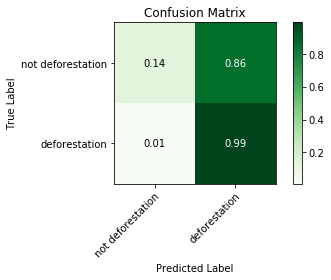

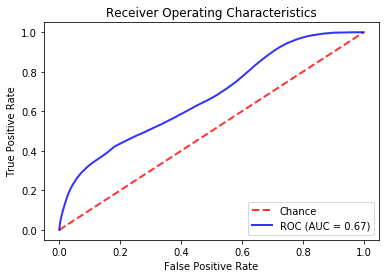

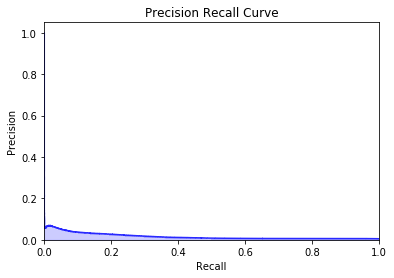

In [8]:
dataset = np.load(val_dataset)
model.validate(dataset['chips'], dataset['labels'], params, model_dir)